## Replication of Grokking experiments 
(checking the relation between attention logits)

In [1]:
import torch
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

In [2]:
from torch import nn

In [3]:
#torch.tensor(math.sin(math.exp(2*i*math.log(10,000)/128)))

In [4]:
pe = torch.zeros([3, 128])
for j in range(3):
    for i in range(0, 128, 2):
        div_term = math.exp(-(math.log(10000.0) * i) / 128)
        pe[j, i] = math.sin(j * div_term)
        pe[j, i + 1] = math.cos(j * div_term)

In [5]:
class embeddings(nn.Module):
    def __init__(self, vocab_size:int = 114, d :int = 128):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, d)

    def forward(self, vocab: list, pe):
        te = self.token_emb(vocab)
        return te #+pe.to(te.dtype)

In [6]:
a = torch.tensor(np.arange(0,113))
b = a
e = torch.ones(12769)*113
e = e.unsqueeze(1)
X = torch.concatenate([torch.cartesian_prod(a, b), e],1)
X = X.long()

In [7]:
dataset_y = (X[:, 0] + X[:,1])%113
y = dataset_y

In [8]:
indices = torch.randperm(len(X))

train_size = int(0.3*len(X))

train_idx = indices[:train_size]
test_idx = indices[train_size:]

train_inputs, train_targets = X[train_idx], y[train_idx]
test_inputs,  test_targets  = X[test_idx],  y[test_idx]

In [9]:
class AttentionModule(nn.Module):
    def __init__(self, d_k = 128, h = 4):
        super().__init__()
        self.query_v1 = nn.Parameter(torch.randn(128,d_k//h))
        self.key_v1 =  nn.Parameter(torch.randn(128,d_k//h))
        self.value_v1 = nn.Parameter(torch.randn(128,d_k//h))

        self.query_v2 = nn.Parameter(torch.randn(128,d_k//h))
        self.key_v2 =  nn.Parameter(torch.randn(128,d_k//h))
        self.value_v2 = nn.Parameter(torch.randn(128,d_k//h))

        self.query_v3 = nn.Parameter(torch.randn(128,d_k//h))
        self.key_v3 =  nn.Parameter(torch.randn(128,d_k//h))
        self.value_v3 = nn.Parameter(torch.randn(128,d_k//h))

        self.query_v4 = nn.Parameter(torch.randn(128,d_k//h))
        self.key_v4 =  nn.Parameter(torch.randn(128,d_k//h))
        self.value_v4 = nn.Parameter(torch.randn(128,d_k//h))

    def forward(self, x):
        Q1 = x @ self.query_v1
        K1 = x @ self.key_v1
        V1 = x @ self.value_v1

        Q2 = x @ self.query_v2
        K2 = x @ self.key_v2
        V2 = x @ self.value_v2
        
        Q3 = x @ self.query_v3
        K3 = x @ self.key_v3
        V3 = x @ self.value_v3

        Q4 = x @ self.query_v4
        K4 = x @ self.key_v4
        V4 = x @ self.value_v4



        att1 = Q1@K1.transpose(-2, -1)/ math.sqrt(32)
        att2 = Q2@K2.transpose(-2, -1)/ math.sqrt(32)
        att3 = Q3@K3.transpose(-2, -1)/ math.sqrt(32)
        att4 = Q4@K4.transpose(-2, -1)/ math.sqrt(32)

        att_soft1 = torch.softmax(att1, dim = -1)
        att_soft2 = torch.softmax(att2, dim = -1)
        att_soft3 = torch.softmax(att3, dim = -1)
        att_soft4 = torch.softmax(att4, dim = -1)

        out1 = att_soft1 @ V1
        out2 = att_soft2 @ V2
        out3 = att_soft3 @ V3
        out4 = att_soft4 @ V4
        out = torch.cat([out1, out2, out3, out4],-1)
        return [att1, att2, att3, att4], out

In [10]:
class ModelArchitecture(nn.Module):
    def __init__(self, n :int, d_k: int, attention: AttentionModule, embedding: embeddings):
        super().__init__()
        self.attention = attention
        self.embedding = embedding
        self.mlp = nn.Sequential(
            nn.Linear(d_k, n),
            nn.ReLU(),
            nn.Linear(n, d_k)
        )
        self.unembed = nn.Linear(d_k, 114, bias = False)

    def forward(self, x):
        att, out = self.attention(self.embedding(x, pe))
        output = self.mlp(out)
        logits = self.unembed(output)
        return att, logits

        

In [ ]:
epochs = 100000

attention = AttentionModule()
embedding = embeddings()
model = ModelArchitecture(n = 512, d_k = 128, attention = attention, embedding = embedding)

optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001, weight_decay = 1)#0.3, 0.5, 1, 3, 5, 8
criterion = nn.CrossEntropyLoss()

In [ ]:
#def compute_weight_norms(model):
#    total_norm_sq = 0.0
#    layer_norms = {}
#
#    for name, param in model.named_parameters():
#        if param.requires_grad:
#            norm = torch.norm(param.data, p=2).item()
#            layer_norms[name] = norm
#            total_norm_sq += norm ** 2
#
#    total_norm = total_norm_sq ** 0.5
#    return total_norm, layer_norms

In [ ]:
import copy

values = []
weight_norm_history = []

prev_epoch_dict = None
prev_total_norm = None

loss_l = float('inf')
accuracy_l = 0.0


for epoch in range(epochs):
   model.train()
   optimizer.zero_grad()
   
   att, logits = model(train_inputs)
   predicted = logits[:, 2, :]
   loss = criterion(predicted, train_targets)
   train_acc = (predicted.argmax(-1) == train_targets).float().mean()

   loss.backward()
   optimizer.step()

   if epoch % 100 == 0:
       model.eval()

       with torch.no_grad():
           att_test, test_logits = model(test_inputs)
           test_predicted = test_logits[:, 2, :]

           test_loss = criterion(test_predicted, test_targets)
           test_acc = (test_predicted.argmax(-1) == test_targets).float().mean()


       logit_magnitude = test_logits.abs().mean().item()

       #total_norm, layer_norms = compute_weight_norms(model)
       #weight_norm_history.append(total_norm)
#
       #if prev_total_norm is not None:
       #    norm_change = (total_norm - prev_total_norm) / prev_total_norm
#
       #    if norm_change > 0.3:
       #        torch.save(model.state_dict(), f"model_weights/{epoch}_weights_norm_spike.pt")
       #        print(f"⚠️ Norm spike at epoch {epoch}")
#
       #prev_total_norm = total_norm
#
       #if prev_epoch_dict is not None:
       #    if test_loss > loss_l * 1.2:
       #        name = f"model_weights/{epoch}_weights_high_loss.pt"
       #        name_prev = f"model_weights/{epoch-100}_weights_prec_low_loss.pt"
       #        torch.save(model.state_dict(), name)
       #        torch.save(prev_epoch_dict, name_prev)
       #    if test_acc >0.9 and accuracy_l < 0.9:
       #        name = f"model_weights/{epoch}_weights_acc_change.pt"
       #        torch.save(model.state_dict(),name)

           
       temp = {
           "train_att": att,
           "test_att": att_test,
           "train_loss": loss.item(),
           "train_acc": train_acc.item(),
           "test_loss": test_loss.item(),
           "test_acc": test_acc.item(),
           #"total_weight_norm": total_norm,
           #"layer_norms": layer_norms,
           #"logit_magnitude" : logit_magnitude
       }

       o = (
           f"| Epoch: {epoch} "
           f"| Train Acc: {train_acc:.4f} "
           f"| Train Loss: {loss:.6f} "
           f"| Test Acc: {test_acc:.4f} "
           f"| Test Loss: {test_loss:.6f} "
           #f"| Total Norm: {total_norm:.4f}"
           #f"| logit_magnitude: {logit_magnitude} |"
       )

       print(o)

       if epoch % 500 == 0:
           values.append(temp)

       with open('epoch_results_logging.log', 'a') as f:
           f.write(f"{o}\n")

       prev_epoch_dict = copy.deepcopy(model.state_dict())
       loss_l = test_loss.item()
       accuracy_l = test_acc.item()


| Epoch: 0 | Train Acc: 0.0097 | Train Loss: 6.099490 | Test Acc: 0.0095 | Test Loss: 6.576663 
| Epoch: 100 | Train Acc: 0.0078 | Train Loss: 4.736198 | Test Acc: 0.0092 | Test Loss: 4.736198 
| Epoch: 200 | Train Acc: 0.0091 | Train Loss: 4.736198 | Test Acc: 0.0088 | Test Loss: 4.736198 
| Epoch: 300 | Train Acc: 0.0078 | Train Loss: 4.736198 | Test Acc: 0.0093 | Test Loss: 4.736198 
| Epoch: 400 | Train Acc: 0.0091 | Train Loss: 4.736198 | Test Acc: 0.0085 | Test Loss: 4.736198 
| Epoch: 500 | Train Acc: 0.0091 | Train Loss: 4.736198 | Test Acc: 0.0087 | Test Loss: 4.736198 
| Epoch: 600 | Train Acc: 0.0086 | Train Loss: 4.736198 | Test Acc: 0.0086 | Test Loss: 4.736198 
| Epoch: 700 | Train Acc: 0.0078 | Train Loss: 4.736198 | Test Acc: 0.0091 | Test Loss: 4.736198 
| Epoch: 800 | Train Acc: 0.0086 | Train Loss: 4.736198 | Test Acc: 0.0091 | Test Loss: 4.736198 
| Epoch: 900 | Train Acc: 0.0089 | Train Loss: 4.736198 | Test Acc: 0.0091 | Test Loss: 4.736198 
| Epoch: 1000 | Train 

In [ ]:
#torch.save(model.state_dict(), 'model_weights/finalmodel_weights.pth')

In [28]:
import json
def tensor_handler(obj):
    if isinstance(obj, torch.Tensor):
        return obj.detach().cpu().tolist()

with open("results_1.json", 'w') as f:
    json.dump(values, f, indent=4, default=tensor_handler)

In [ ]:
#attention = AttentionModule()
#embedding = embeddings()
#model = ModelArchitecture(n=512, d_k=128, attention=attention, embedding=embedding)
#
#model.load_state_dict(torch.load('model_weights.pth'))
#model.eval()

ModelArchitecture(
  (attention): AttentionModule()
  (embedding): embeddings(
    (token_emb): Embedding(114, 128)
  )
  (mlp): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
  )
  (unembed): Linear(in_features=128, out_features=114, bias=False)
)

In [ ]:
#a_val = 10
#b_range = torch.arange(113)
#equals_token = torch.tensor([113] * 113)
#a_fixed = torch.tensor([a_val] * 113)
#
#input_data = torch.stack([a_fixed, b_range, equals_token], dim=1).long()

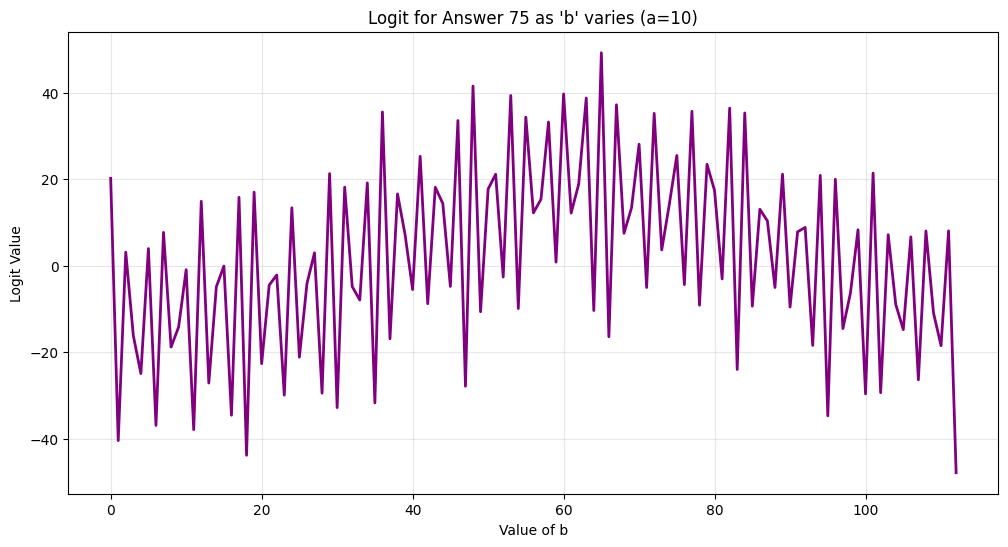

In [ ]:
#with torch.no_grad():
#    _, logits = model(input_data)
#    answer_to_track = 75 
#    curves = logits[:, 2, answer_to_track].numpy()
#
## Plotting the curve
#plt.figure(figsize=(12, 6))
#plt.plot(b_range.numpy(), curves, color='purple', linewidth=2)
#plt.title(f"Logit for Answer {answer_to_track} as 'b' varies (a={a_val})")
#plt.xlabel("Value of b")
#plt.ylabel("Logit Value")
#plt.grid(True, alpha=0.3)
#plt.savefig(f'grokking_pattern_observed.png', dpi=300)
#plt.show()